In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

import db_conn

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine


In [2]:
def create_earthquake_dict(r):
    return {
    "magnitude" : float(r[0]),
    "place": r[1],
    "time": int(r[2]),
    "timezone": float(r[3]),
    "url": r[4],
    "tsunami" :  int(r[5]),
    "ids" : r[6],
    "specific_type" :  r[7],
    "geometry" :  r[8],
    "country" : r[9],
    "lat" : float(r[10]),
    "lng" :  float(r[11]),
    "depth" :  float(r[12])
    }

In [3]:
sel = [db_conn.earthquakes.magnitude, db_conn.earthquakes.place, db_conn.earthquakes.time, db_conn.earthquakes.timezone, db_conn.earthquakes.url, db_conn.earthquakes.tsunami, db_conn.earthquakes.ids, db_conn.earthquakes.specific_type, db_conn.earthquakes.geometry, db_conn.earthquakes.country_de, db_conn.earthquakes.lng, db_conn.earthquakes.lat, db_conn.earthquakes.depth]

In [4]:
all_results = db_conn.session.query(*sel).all()

In [35]:
all_earthquakes = []

for r in all_results:
    transformed_dict = create_earthquake_dict(r)
    all_earthquakes.append(transformed_dict)


df = pd.DataFrame(all_earthquakes)

In [36]:
# df.head(n=2)

In [76]:
DROP_COLUMNS = ["ids", "geometry", "place", "url", "country", "specific_type", "timezone", "time", "depth", "magnitude"]
lat_lng_mag_tsu = df.drop(DROP_COLUMNS, axis = 1)

In [77]:
lat_lng_mag_tsu.head(n=3)

,lat,lng,tsunami
0,34.142666,-117.026665,0
1,-1.753100,-13.039500,0
2,-56.278100,-27.237200,0


In [78]:
y = lat_lng_mag_tsu["tsunami"].values
X = lat_lng_mag_tsu.drop('tsunami', axis=1).values

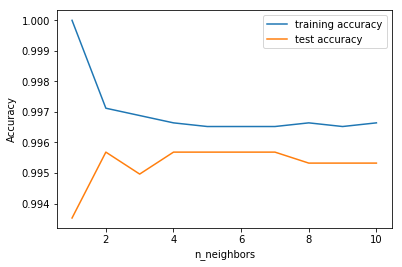

In [79]:
# Tsunami magnitude lat and lng
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [94]:
DROP_COLUMNS = ["ids", "geometry", "place", "url", "country", "specific_type", "time", "timezone"]
plot2 = df.drop(DROP_COLUMNS, axis = 1)
plot2.head()

,depth,lat,lng,magnitude,tsunami
0,6.86,34.142666,-117.026665,1.29,0
1,10.00,-1.753100,-13.039500,5.00,0
2,104.96,-56.278100,-27.237200,5.30,0
3,10.00,22.280700,122.507200,5.20,0
4,-0.60,19.419167,-155.281174,2.07,0


/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


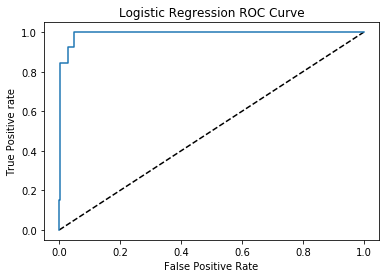

In [95]:
from sklearn.metrics import roc_curve
logreg = LogisticRegression()

y = plot2["tsunami"].values
X = plot2.drop(['tsunami'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label="Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("Logistic Regression ROC Curve")
plt.show()

In [97]:
DROP_COLUMNS = ["ids", "geometry", "place", "url", "country", "specific_type", "time", "timezone", "lat", "lng"]
plot3 = df.drop(DROP_COLUMNS, axis = 1)
plot3.head()

,depth,magnitude,tsunami
0,6.86,1.29,0
1,10.00,5.00,0
2,104.96,5.30,0
3,10.00,5.20,0
4,-0.60,2.07,0


/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


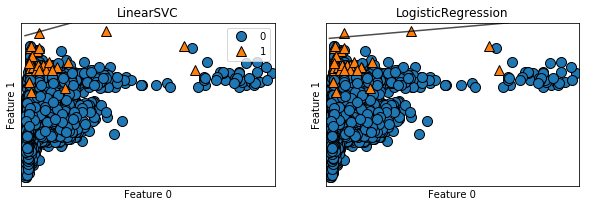

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

y = plot3["tsunami"].values
X = plot3.drop(['tsunami'], axis=1).values


fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for model, ax in zip([LinearSVC(), LogisticRegression()], axes):
    clf = model.fit(X, y)
    mglearn.plots.plot_2d_separator(clf, X, fill=False, eps=0.5,
                                    ax=ax, alpha=.7)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title(clf.__class__.__name__)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
axes[0].legend()

In [109]:
DROP_COLUMNS = ["ids", "geometry", "place", "url", "country", "specific_type", "time", "timezone", "lat", "lng"]
plot4 = df.drop(DROP_COLUMNS, axis = 1)

y = plot4["tsunami"].values
X = plot4.drop(['tsunami'], axis=1).values

In [112]:
plot4.head()

,depth,magnitude,tsunami
0,6.86,1.29,0
1,10.00,5.00,0
2,104.96,5.30,0
3,10.00,5.20,0
4,-0.60,2.07,0


In [113]:
linear_svm = LinearSVC().fit(X, y)
print("Coefficient shape: ", linear_svm.coef_.shape)
print("Intercept shape: ", linear_svm.intercept_.shape)

Coefficient shape:  (1, 2)
Intercept shape:  (1,)


/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'Feature 1')

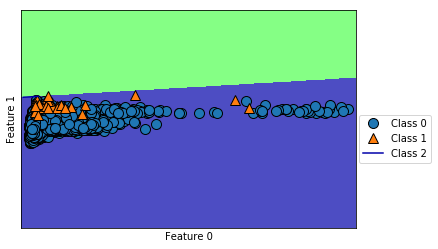

In [111]:
mglearn.plots.plot_2d_classification(linear_svm, X, fill=True, alpha=.7)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
                                  mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
            'Line class 2'], loc=(1.01, 0.3))
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [99]:
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.996
Test set score: 0.995


In [115]:
import numpy as np
def compute_log_loss(predicted, actual, eps=1e-14):

    predicted = np.clip(predicted, eps, 1 - eps)
    loss = -1 * np.mean(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))
    return loss

In [116]:
compute_log_loss(0.996,0.995)

0.03159528587986238

In [ ]:
# DROP_COLUMNS = ["ids", "geometry", "place", "url", "country", "specific_type", "timezone", "time", "depth"]
# tsnuma_mag = df.drop(DROP_COLUMNS, axis = 1)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for model, ax in zip([LinearSVC(), LogisticRegression()], axes):
    clf = model.fit(X, y)
    mglearn.plots.plot_2d_separator(clf, X, fill=False, eps=0.5,
                                    ax=ax, alpha=.7)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title(clf.__class__.__name__)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
axes[0].legend()

array([0, 0, 0, ..., 0, 0, 0])

In [117]:
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))

confusion = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

NameError: name 'pred_logreg' is not defined

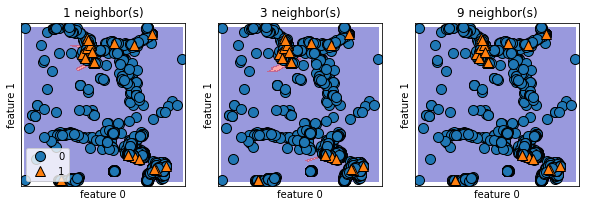

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for n_neighbors, ax in zip([1, 3, 9], axes):
    # the fit method returns the object self, so we can instantiate
    # and fit in one line
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    mglearn.plots.plot_2d_separator(clf, X, fill=True, eps=0.5, ax=ax, alpha=.4)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title("{} neighbor(s)".format(n_neighbors))
    ax.set_xlabel("feature 0")
    ax.set_ylabel("feature 1")
axes[0].legend(loc=3)